# **Análise de risco e Otimização de Portfólio com python**

- Calcular os retornos diários
- Calcular Retornos logarítmicos
- Visualização em Histograma
- Calcular Desvio-Padrão / Volatilidade diária e anual.
- Drawndown
- Downside Risk
- Semivariância
- Modelo CAPM
- Beta
- Value at Risk
- Simulação de Monte Carlo (VaR)
- Modelos de Otimização de Mínima-Volatilidade
- Modelos de Otimização de Maximização do índice de Sharpe
- Modelos de Otimização de Risco Eficiente 
- Modelos de Otimização de Retorno Eficiente 
- Modelos de Otimização com Restrições Setoriais e por um Ativo específico 

<br>

### **Risco:**


Risco é definido como a **variabilidade dos retornos 
observados de um investimento em comparação com seus retornos 
esperados.**

<br>

Isso implica em **duas questões:**

- **1°** ter um método adequado para quantificar essa “variabilidade dos retornos observados” e;

- **2°** ter outro método também para estimar os retornos futuros.

<br>

<br>

### **Seleção de ações e montagem de um Portfólio de investimento:**


Em 1934 Benjamim Graham relatava em seus estudos que a 
volatilidade baseada no histórico dos preços de nada adiantava
como proxy para o risco, pois **as quedas nos preços dos ativos 
podem ser passageiras e não representar o verdadeiro valor do ativo
(Value Investing).**

<br>

Em 1952, Harry Markowitz mudou completamente o panorama de
portfólio de investimento dando um passo à frente em relação a 
diversificação de ativos dentro de uma carteira. **O risco da carteira deveria ser 
menor que o risco individual de cada ativo, caso contrário a 
diversificação não estava sendo eficiente.**

<br>

**Os ativos que compõe a carteira e os pesos de cada ativo em seu portfólio são as unicas alavancas que estão sob seu total controle.**

<br>

<br>

## **Analisar o comportamento de um ativo individualmente**

<br>

In [99]:
# Importação de bibliotecas
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from functools import reduce
import statsmodels.api as sm
from scipy.stats import norm
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import objective_functions

In [14]:
# Seleção de uma ação ITUB3 (ITAÚ)
ativo = 'ITUB3.SA'
start_date = '2017-01-01'
end_date = '2024-01-01'

# risco individual do ativo ITUB3
itau_prices = yf.download(ativo, start = start_date, end = end_date)
itau_prices

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-02,19.700001,19.926666,19.573334,19.780001,13.494702,63750
2017-01-03,19.959999,20.393333,19.886665,20.373333,13.899498,107700
2017-01-04,20.266666,20.666666,20.266666,20.666666,14.099625,135600
2017-01-05,20.533333,20.740000,20.393333,20.706667,14.126919,208650
2017-01-06,20.733334,21.033333,20.446667,20.733334,14.145111,86400
...,...,...,...,...,...,...
2023-12-21,27.980000,28.160000,27.860001,28.090000,26.793102,433300
2023-12-22,28.040001,28.660000,28.040001,28.309999,27.002945,472100
2023-12-26,28.309999,28.700001,28.240000,28.639999,27.317707,266600


In [15]:
# Iremos eliminar as demais colunas (High, Low, Open, Close e Volume), e renomear para ITAU.
itau_prices.rename(columns = {'Adj Close':'ITAÚ'}, inplace = True)
itau = itau_prices.drop(itau_prices.columns[[0,1,2,3,5]], axis = 1)

In [16]:
itau

,ITAÚ
Date,
2017-01-02,13.494702
2017-01-03,13.899498
2017-01-04,14.099625
2017-01-05,14.126919
2017-01-06,14.145111
...,...
2023-12-21,26.793102
2023-12-22,27.002945
2023-12-26,27.317707


In [17]:
# Para calcular os retornos diários: (Preço Final – Preço inicial)/Preço Final ou pct_change()
itau_returns = itau.pct_change()

In [18]:
itau_returns.head()

,ITAÚ
Date,
2017-01-02,NaN
2017-01-03,0.029997
2017-01-04,0.014398
2017-01-05,0.001936
2017-01-06,0.001288


In [19]:
# Muitos códigos e artigos acadêmicos vemos os retornos sendo calculados através do famoso “log-return”,
# que são os retornos logarítmicos dos preços, esses representam melhor os retornos acumulados que o
# retorno linear.

itau_log_returns = np.log(itau/itau.shift(1))

In [20]:
itau_log_returns.head()

,ITAÚ
Date,
2017-01-02,NaN
2017-01-03,0.029556
2017-01-04,0.014295
2017-01-05,0.001934
2017-01-06,0.001287


<br>

## **Calcular a volatilidade dos retornos**

<br>

In [21]:
# Visualizando os retornos - Gráfico de Linha

# Criar uma figura
fig = go.Figure()

# Adicionar a linha do gráfico
fig.add_trace(go.Scatter(x=itau_log_returns.index, y=itau_log_returns['ITAÚ'], mode='lines', name='Itaú Log Returns'))

# Atualizar o layout do gráfico
fig.update_layout(title='Itaú Log Returns Over Time',
                   xaxis_title='Date',
                   yaxis_title='Log Returns',
                   xaxis=dict(type='date'),
                   yaxis=dict(type='linear'))

# Exibir o gráfico interativo
fig.show()

In [11]:
# Visualizando os retornos - Histograma

# Criar a figura do histograma
fig = go.Figure()

# Adicionar o histograma ao gráfico
fig.add_trace(go.Histogram(x=itau_log_returns['ITAÚ'], nbinsx=100, name='Itaú Log Returns'))

# Atualizar o layout do gráfico
fig.update_layout(title='Histogram of Itaú Log Returns',
                   xaxis_title='Log Returns',
                   yaxis_title='Frequency')

# Exibir o gráfico interativo
fig.show()

<br>

O risco de um ativo é representado pela **volatilidade dos retornos apresentados** ao longo do tempo.

**A melhor forma de calcular essa volatilidade é através do desvio-padrão.**

<br>

<br>

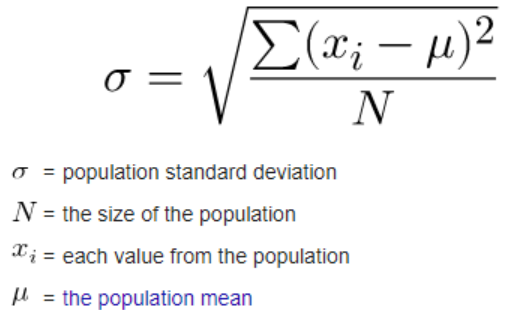

<br>

**O desvio-padrão é uma medida de dispersão, ou seja, nos auxilia a enxergar quão longe da média estão os valores da amostra.**

<br>

<br>

No mercado todo ativo está exposto a basicamente dois tipos de risco:

- **Risco sistemático –** afeta os ativos do portfólio da mesma maneira, exemplo disso é a economia em si. 

- **Risco intrínseco -** afeta especificamente um ativo (risco relacionado ao negócio).

<br>


In [22]:
itau_returns

,ITAÚ
Date,
2017-01-02,NaN
2017-01-03,0.029997
2017-01-04,0.014398
2017-01-05,0.001936
2017-01-06,0.001288
...,...
2023-12-21,0.004290
2023-12-22,0.007832
2023-12-26,0.011657


In [23]:
# Para calcular o desvio padrão em Python utilizaremos a biblioteca Numpy com a função .std()
volatilidade_diaria = np.std(itau_returns['ITAÚ'])

In [26]:
print(volatilidade_diaria * 100) 

1.77902194853647


In [ ]:
# Para calcularmos em bases anuais, basta multiplicarmos pela raiz 252 dias úteis:

In [27]:
volatilidade_anual = volatilidade_diaria*np.sqrt(252)

In [28]:
print(volatilidade_anual * 100)

28.24109791651829


<br>

## **Drawdown, Semivariância e Downside Risk**

<br>


<br>

- Existe uma limitação importante no método de calcular risco de um
ativo através do desvio padrão: a fórmula leva em consideração
tanto os retornos **positivos quanto negativos, atribuindo para os 
dois o mesmo peso.**

<br>

- Abordaremos uma maneira mais ponderada de observar os retornos 
a partir de uma **perspectiva de perdas.**

<br>

<br>

**Risco de Perda Potencial ou Downside Risk**

<br>

Downside Risk é um termômetro da volatilidade relacionada às 
perdas do ativo.

<br>

- Vamos descobrir o **drawndown**, que é baseado no histórico do ativo, qual 
foi a maior queda ocorrida no período  do investimento e calcular a **volatilidade dos 
retornos negativos.**

<br>

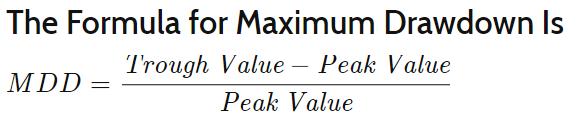

<br>

- Enquanto o downside risk se concentra na volatilidade dos retornos negativos, o drawdown se concentra nas quedas máximas do valor de um investimento em relação a um ponto anterior no tempo. 

<br>

- **A semivariância é uma alternativa ao desvio padrão tradicional**, que
calcula a dispersão entre os **valores que estão abaixo da média da 
amostra.**

<br>

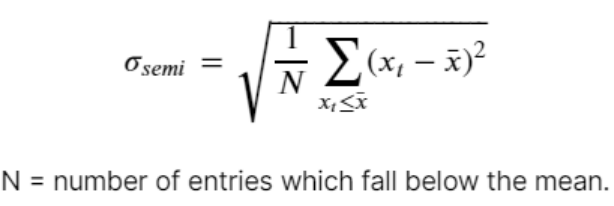

<br>

In [29]:
# Iremos calcular o desvio padrão dos retornos que estão abaixo de zero, ou seja, aqueles 
# retornos que representam as perdas diárias.
semivariancia = np.std(itau_returns['ITAÚ']<0)

In [30]:
# Como resultado temos um número bem maior do que a alternativa do desvio padrão
print(semivariancia * 100)

49.95107436735699


In [31]:
# Agora vamos seguir um passo a passo para calcular o Drawdown

# 1) Calcular os retornos acumulados em base 100
retorno_acumulado = itau_log_returns * 100

In [32]:
# 2) Retirar os NaNs e substituí-los por zero
retorno_acumulado = retorno_acumulado['ITAÚ'].fillna(0) 

In [33]:
# 3) Calcular o ponto máximo dos acumulados utilizando o Numpy e garantir que não fique abaixo de 1
ponto_maximo = np.maximum.accumulate(retorno_acumulado)
ponto_maximo[ponto_maximo < 1] = 1

In [34]:
# 4) Calcular o drawdown
drawdown = (retorno_acumulado) / ponto_maximo - 1

In [35]:
# Transformando em DataFrame
drawdown = pd.DataFrame(drawdown)

In [36]:
# renomeando colunas
drawdown.rename(columns = {'ITAÚ':'ITAÚ Drawdown'}, inplace = True)

In [37]:
drawdown

,ITAÚ Drawdown
Date,
2017-01-02,-1.000000
2017-01-03,0.000000
2017-01-04,-0.516319
2017-01-05,-0.934566
2017-01-06,-0.956457
...,...
2023-12-21,-0.959094
2023-12-22,-0.925457
2023-12-26,-0.889265


In [38]:
fig = go.Figure()

# Adicionar a linha do gráfico
fig.add_trace(go.Scatter(x=drawdown.index, y=drawdown['ITAÚ Drawdown'], name='Drawdown'))

# Atualizar o layout do gráfico
fig.update_layout(title='Drawdown Over Time',
                   xaxis_title='Date',
                   yaxis_title='Drawdown',
                   xaxis=dict(type='date'),
                   yaxis=dict(type='linear'))

# Exibir o gráfico interativo
fig.show()

<br>

## **Modelo CAPM e coeficiente Beta**

<br>

<br>

**O Modelo CAPM**

<br>

- O modelo CAPM (Capital Asset Pricing Model) foi desenvolvido em 
1961 por Bill Sharpe e John Lintner e Jack Treynor, e pretende 
**estabelecer uma relação entre o ativo analisado e sua sensibilidade ao 
risco sistemático de mercado.**

<br>

- O modelo tem o prêmio sobre o risco 
como seu principal pilar, somamos a taxa livre de risco com o 
produto entre beta o prêmio pelo risco.

<br>

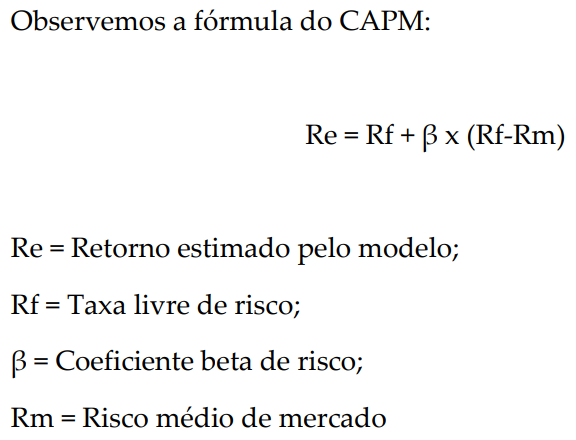

<br>

**O Beta**

<br>

- O beta serve como um **índice de sensibilidade do ativo ao mercado.**

<br>

- **A taxa livre de risco expressa a taxa de remuneração do ativo que o 
investidor tem certeza que receberá sua remuneração na data e na 
quantia prometida** e o **prêmio pelo risco expressa quanto o 
investidor está disposto a pagar “a mais” por esse ativo tendo em 
vista que possui a alternativa livre de risco para investir**, ou seja, o 
ágio sobre a taxa livre de risco.

<br>

- É Um número ao redor de 1, onde betas **acima desse valor são 
investimentos considerados mais arriscados que o mercado** e o 
oposto também é verdadeiro, **betas com valores inferiores a 1 são 
menos arriscados.**

<br>

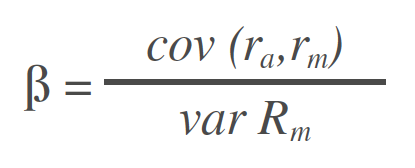

<br>

- β = Covariância do ativo com a carteira de mercado/ Variância da 
carteira de mercado


<br>

In [44]:
# Iremos utilizar o Ibovespa como referência de carteira de mercado 

# 1) Importar o Ibovespa e dar o mesmo tratamento de dados anterior que demos a ITAU
ibov = yf.download('^BVSP', start = '2017-01-01', end = '2024-01-01')
ibov.rename(columns = {'Adj Close':'IBOV'}, inplace = True)
ibov = ibov.drop(ibov.columns[[0,1,2,3,5]], axis = 1)
ibov_returns = np.log(ibov/ibov.shift(1))

[*********************100%%**********************]  1 of 1 completed


In [45]:
ibov

,IBOV
Date,
2017-01-02,59589.0
2017-01-03,61814.0
2017-01-04,61589.0
2017-01-05,62071.0
2017-01-06,61665.0
...,...
2023-12-21,132182.0
2023-12-22,132753.0
2023-12-26,133533.0


In [46]:
ibov_returns

,IBOV
Date,
2017-01-02,NaN
2017-01-03,0.036659
2017-01-04,-0.003647
2017-01-05,0.007796
2017-01-06,-0.006562
...,...
2023-12-21,0.010480
2023-12-22,0.004310
2023-12-26,0.005858


In [47]:
# 2) Calcular a variância do ibov
ibov_var = ibov_returns.var()

In [48]:
ibov_var

IBOV    0.000251
dtype: float64

In [49]:
# 3) Juntar os dataframes 
join_itau_ibov = ([itau_log_returns, ibov_returns])
cov_itau = reduce(lambda left, right: pd.merge(left, right, on=['Date'], how = 'inner'), join_itau_ibov)

In [50]:
join_itau_ibov

[                ITAÚ
 Date                
 2017-01-02       NaN
 2017-01-03  0.029556
 2017-01-04  0.014295
 2017-01-05  0.001934
 2017-01-06  0.001287
 ...              ...
 2023-12-21  0.004281
 2023-12-22  0.007801
 2023-12-26  0.011589
 2023-12-27  0.005571
 2023-12-28  0.001388
 
 [1741 rows x 1 columns],
                 IBOV
 Date                
 2017-01-02       NaN
 2017-01-03  0.036659
 2017-01-04 -0.003647
 2017-01-05  0.007796
 2017-01-06 -0.006562
 ...              ...
 2023-12-21  0.010480
 2023-12-22  0.004310
 2023-12-26  0.005858
 2023-12-27  0.004938
 2023-12-28 -0.000067
 
 [1733 rows x 1 columns]]

In [51]:
cov_itau

,ITAÚ,IBOV
Date,,
2017-01-02,NaN,NaN
2017-01-03,0.029556,0.036659
2017-01-04,0.014295,-0.003647
2017-01-05,0.001934,0.007796
2017-01-06,0.001287,-0.006562
...,...,...
2023-12-21,0.004281,0.010480
2023-12-22,0.007801,0.004310
2023-12-26,0.011589,0.005858


In [52]:
cov_itau

,ITAÚ,IBOV
Date,,
2017-01-02,NaN,NaN
2017-01-03,0.029556,0.036659
2017-01-04,0.014295,-0.003647
2017-01-05,0.001934,0.007796
2017-01-06,0.001287,-0.006562
...,...,...
2023-12-21,0.004281,0.010480
2023-12-22,0.007801,0.004310
2023-12-26,0.011589,0.005858


In [53]:
# 4) Montar a matriz de covariância [ITAÚ,IBOV] e encontrar o coeficiente
cov_itau = cov_itau[['ITAÚ','IBOV']].cov()
cov_itau_coef = cov_itau.iloc[0,1]

In [54]:
cov_itau_coef

0.00021355100765797644

In [55]:
# 5) Calcular o beta dividindo o coeficiente de covariância dividindo pela variância do Ibov
beta_itau = cov_itau_coef / ibov_var

In [56]:
beta_itau

IBOV    0.850587
dtype: float64

<br>

## **Calculando o beta através da regressão linear**

<br>

A regressão linear das taxas de retorno de uma ação (ITUB3) e dos 
retornos do índice de mercado (IBOV) é uma abordagem alternativa
ao quociente entre covariância e variância. O beta é calculado a 
partir da inclinação da reta de regressão. Retas mais positivamente 
inclinadas indicam betas maiores, ou seja, mais sensíveis as
variações do mercado.

<br>

In [57]:
# Dropando NaNs gerados pelo cálculo da variação diária 
itau_returns.dropna(inplace = True)
ibov_returns.dropna(inplace = True)

In [58]:
# Alinhando os índices dos DataFrames
itau_ibov_returns = itau_returns.join(ibov_returns, how='inner')

# Separando e variáveis diferentes
endog = itau_ibov_returns['ITAÚ']
exog = itau_ibov_returns['IBOV']

# Definir a variável beta no método OLS (Ordinary Least Squares)
beta = sm.OLS(endog, exog).fit()

In [59]:
# 3) Chamar o método summary para observar os resultados
print(beta.summary())

                                 OLS Regression Results                                
Dep. Variable:                   ITAÚ   R-squared (uncentered):                   0.565
Model:                            OLS   Adj. R-squared (uncentered):              0.565
Method:                 Least Squares   F-statistic:                              2249.
Date:                Fri, 22 Mar 2024   Prob (F-statistic):                   3.10e-315
Time:                        10:42:43   Log-Likelihood:                          5236.9
No. Observations:                1732   AIC:                                 -1.047e+04
Df Residuals:                    1731   BIC:                                 -1.047e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

<br>
    
- A variével **'coef' de 0.8462** é o nosso **beta.**
- No caso da interpretação do Beta da ITAÚ temos que para cada 
**1% de variação do IBOVESPA temos uma variação de 0.8462% no 
retorno das ações** dentro do período analisado. 

<br>

- A variável **'R-squared' de 0.565** mostra quanto das variações do retorno do IBOVESPA explicam as variações nos retornos da ITAÚ, nesse caso **56,5%.**

<br>

<br>

## **Value At Risk**

<br>


<br>

**Value At Risk**

<br>

- O value at risk é uma medida que mostra para o investidor qual o 
potencial de perda daquele ativo ou de sua carteira como um todo.

<br>

- O indicador mede o pior cenário que esse ativo ou carteira pode 
atingir, dadas as condições normais de mercado e um determinado 
nível de confiança.

<br>

- O conceito de VaR está intimamente ligado a quantificar uma 
probabilidade de perda se as coisas ocorrerem como sempre 
ocorreram. O VaR é normalmente medido em três intervalos de confiança: 90%, 
95% e 99%

<br>

- O VaR é utilizado por bancos e fundos de investimento para saber 
qual o custo de carrego das posições tomadas em ativos, pois 
sabendo dentro de um intervalo de confiança quanto posso perder, 
consigo gerenciar meu risco com um colchão de liquidez para cobrir 
eventuais perdas.

<br>

*exemplo: Uma carteira de investimentos com VaR de 5 mil reais em um mês à 
um intervalo de significância de 95 por cento, nos indica que existe 5 por cento de 
chance dessa carteira perder mais que 5 mil reais no período de trinta 
dias, dentro de condições normais de mercado.*

<br>

<br>

**Distribuição Normal**

<br>

- A distribuição normal é utilizada para estimar probabilidades em 
diversos eventos como seguros, risco de default em crédito, fluxos 
de caixa e no mercado financeiro os retornos de ações.

<br>

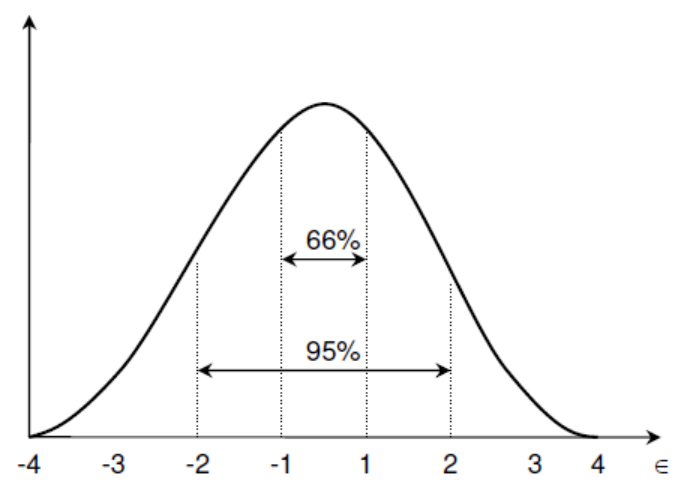

<br>

- Na regra da distribuição normal temos que 
**95% das observações estão em um espaço de -2 e + 2 desvio-padrão**
e **66% está entre -1 e +1.** Dessa forma podemos estimar 
probabilidades de ocorrência de resultados, tanto positivo quanto 
negativos se a distribuição dos retornos das ações tiver
comportamento normal.


In [60]:
# VaR Simulação histórica
var_90 = np.percentile(itau_returns, 10)
var_95 = np.percentile(itau_returns, 5)
var_99 = np.percentile(itau_returns, 1)
print('========================================')
print('         VaR SIMULAÇÃO HISTÓRICA ')
print('========================================')
print('-> Intervalo de confiança 90%: {:.4f} |'.format(var_90 * 100))
print('----------------------------------------')
print('-> Intervalo de confiança 95%: {:.4f} |'.format(var_95 * 100))
print('----------------------------------------')
print('-> Intervalo de confiança 99%: {:.4f} |'.format(var_99 * 100))
print('========================================')

         VaR SIMULAÇÃO HISTÓRICA 
-> Intervalo de confiança 90%: -1.9117 |
----------------------------------------
-> Intervalo de confiança 95%: -2.5218 |
----------------------------------------
-> Intervalo de confiança 99%: -4.0407 |


In [61]:
itau_returns

,ITAÚ
Date,
2017-01-03,0.029997
2017-01-04,0.014398
2017-01-05,0.001936
2017-01-06,0.001288
2017-01-09,-0.004180
...,...
2023-12-21,0.004290
2023-12-22,0.007832
2023-12-26,0.011657


In [62]:
# VaR Paramétrico 

# 1) Depois calcular as médias dos retornos através da variável media:
media = np.mean(itau_returns['ITAÚ'])

In [63]:
# 2) Definir as variáveis dos intervalos de confiança:
conf_90 = 0.1
conf_95 = 0.05
conf_99 = 0.01

VaR_90 = norm.ppf(conf_90, media, volatilidade_diaria)
VaR_95 = norm.ppf(conf_95, media, volatilidade_diaria)
VaR_99 = norm.ppf(conf_99, media, volatilidade_diaria)

In [64]:
print('========================================')
print('             VaR PARAMÉTRICO  ')
print('========================================')
print('-> Intervalo de confiança 90%: {:.4f} |'.format(VaR_90 * 100))
print('----------------------------------------')
print('-> Intervalo de confiança 95%: {:.4f} |'.format(VaR_95 * 100))
print('----------------------------------------')
print('-> Intervalo de confiança 99%: {:.4f} |'.format(VaR_99 * 100))
print('========================================')

             VaR PARAMÉTRICO  
-> Intervalo de confiança 90%: -2.2230 |
----------------------------------------
-> Intervalo de confiança 95%: -2.8693 |
----------------------------------------
-> Intervalo de confiança 99%: -4.0817 |


VaR_95% gerou um resultado de -2.86? Quer dizer que existe uma
chance de 5% (1-95%) de ocorrer uma perde de -2.86% ou mais no dia 
nas ações do ITUB3.

<br>

**Simulação de Monte Carlo aplicada ao VaR**

<br>

- A simulação de Monte Carlo aplicada ao VaR é uma mistura das 
ferramentas contidas no VaR paramétrico com o histórico. O método
da simulação de Monte Carlo surgiu em 1946 com Stanislaw Ulam a 
partir de um problema de probabilidades e análise combinatória. O 
modelo faz simulações dentro de uma distribuição de 
probabilidades dos retornos que detêm média = mu e desvio-padrão 
= desv_pad e a partir disso podemos calcular o percentil que a perda 
está inserida, assim como fizemos como VaR histórico.

<br>


In [65]:
# VaR Simulação de Monte Carlo

# 1) Definir o dataset retornos_simulados em branco para abrigar as iterações da simulação
retornos_simulados = []

In [66]:
# 2) Criar a variável dias_trade para 252 dias pois estamos analisando retornos diários
dias_trade = 252

In [67]:
# 3) Criar um loop de 1000 iterações para a Simulação de Monte Carlo
for i in range(1000):
    sim_retornos = np.random.normal(media, volatilidade_diaria, dias_trade)

In [68]:
# 4) Anexar as iterações no df retornos_simulados
retornos_simulados.append(sim_retornos)

In [69]:
# 5) Calcular o percentil relacionado ao VaR desejado
var_99 = np.percentile(retornos_simulados, 1)

In [70]:
retornos_simulados

[array([ 2.46501327e-02, -2.31183895e-02, -1.75072337e-02, -2.33915353e-02,
         1.68408962e-02,  2.85412477e-02, -9.00667808e-03,  1.49738242e-03,
         3.92436369e-02,  1.36185734e-03, -1.02967026e-02, -1.01249237e-03,
        -1.91942878e-02, -1.95514006e-02,  4.10194500e-03, -7.27088446e-03,
        -9.30844875e-03,  1.07031401e-02, -1.38377140e-02, -7.61845564e-03,
         2.05724746e-02,  3.35297136e-02, -1.25813529e-02,  7.60869889e-03,
        -1.28618828e-02,  3.83415112e-04, -1.37715498e-02,  1.08571974e-02,
        -1.35555126e-02, -5.20107283e-03, -4.57872018e-03, -6.73852249e-03,
         1.21549469e-02,  8.22050063e-03,  2.70442842e-02,  2.27641625e-02,
        -4.68759187e-03,  1.27384434e-02,  1.90814413e-02, -3.72223205e-03,
        -5.42188709e-02, -1.39141759e-02,  2.48732230e-02, -1.87997435e-02,
         1.95039947e-02, -2.06727010e-02,  3.13299646e-02, -1.52332047e-02,
         2.00737733e-02,  9.39965874e-03,  1.76524694e-02,  1.44615943e-02,
         2.1

In [71]:
var_99 * 100

-4.112631849726556

<br>

## **Otimização de portfólios de investimento**

<br>


<br>

**A otimização de média-variância que foi primeiramente proposta 
por Harry Markowitz**

<br>

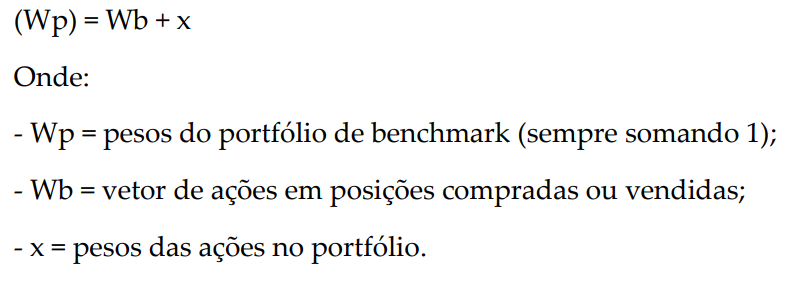


<br>

Para otimizar esse portfólio temos como objetivo minimizar a 
função como ocorre abaixo:

<br>

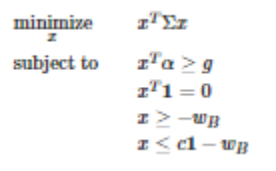

<br>

- Portanto, os retornos devem ser maiores que o retorno alvo da 
carteira xT α ≥g, os pesos da carteira devem somar 1.

<br>

- A biblioteca utilizada para otimização de portfólio será a 
PyPortfolioOpt, para dados do Ibovespa a PyPortfolioOpt é mais indicada por uma gama maior de 
parâmetros customizáveis.

<br>

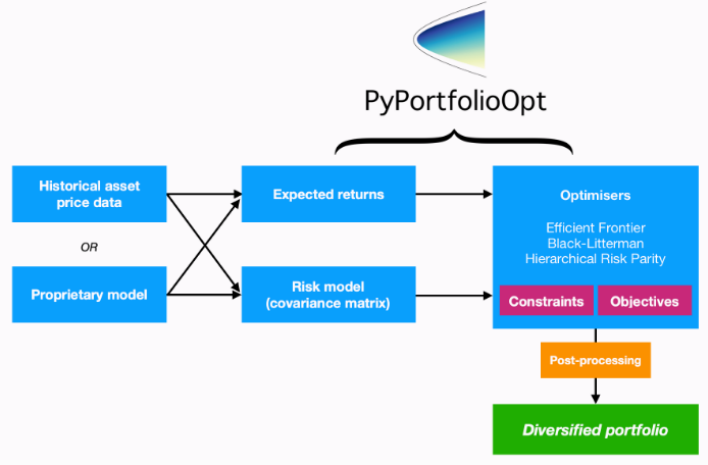

<br>

- Primeiro passo precisamos de uma matriz de preços históricos que 
servirão como base para criar os retornos esperados. 

<br>

- O segundo momento é construir a matriz de covariância ou modelo 
de risco.

<br>

- A terceira etapa é selecionar o método de otimização desejado e a 
partir disso ou adicionar alguma restrição ou objetivo desejado. O 
modelo permite ainda que você faça algumas alterações depois de 
processada a otimização para uma melhor calibração dos pesos da 
carteira.

In [72]:
# Ações utilizadas: ITUB4,ABEV3, PETR4, VALE3, BBAS3
# 1) Criar uma lista com os tickers das ações (da mesma maneira que está escrito no Yahoo Finance):
ativos = ['ITUB4.SA','ABEV3.SA','PETR4.SA','VALE3.SA','BBAS3.SA']

In [73]:
# 2) Criar um dataframe vazio para abrigar os dados que vamos coletar:
df = pd.DataFrame()

In [74]:
# 3) Fazer um loop para preencher o df com os dados das ações com o campo ‘Adj Close’
for t in ativos:
    df[t] = yf.download(t, start = '2018-01-01', end = '2020-01-01')['Adj Close']

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


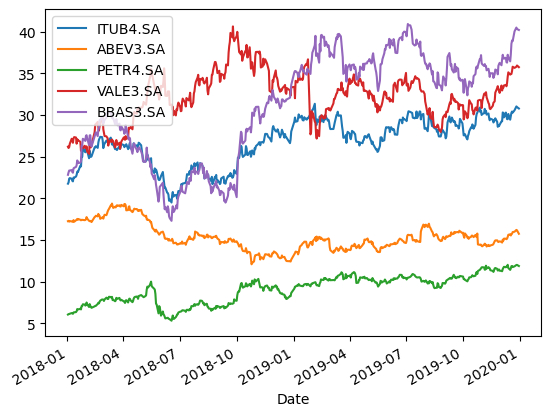

In [75]:
df.plot();

In [76]:
retorno = df.pct_change()

Entretanto para comparar desempenho entre as ações devemos
utilizar o crescimento composto que coloca os retornos em base 100

In [77]:
# Retornos Esperados 
# separar o df em dois anos (250 dias de pregão) 
df_fut, df_past = df.iloc[:-250], df.iloc[-250:]

Dessa maneira poderemos utilizar o df_past para prever os valores e 
o df_fut para comparar os valores reais com os preditos para depois 
comparar qual o método mais efetivo

<br>

Para isso utilizaremos o erro 
médio absoluto:

<br>

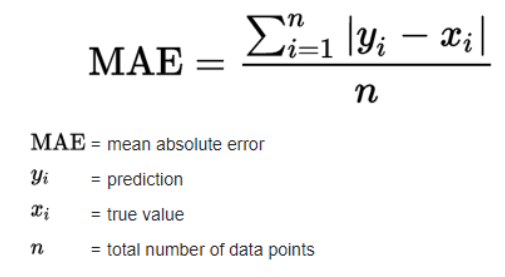

<br>

- O erro médio absoluto calcula a média da diferença entre o valor 
real e o valor estimado em módulo, dessa forma evita-se os 
resultados negativos.

<br>

Ferramentas para estimar retorno – PyPortfolio 

<br>

- Retorno Médio Histórico
    - Calcula a média aritmética de retornos anualizada

<br>

- Média Móvel Exponencial
    - Calcula a média exponencial ponderada, ou seja, a média dos últimos n preços com a ponderação sendo reduzida exponencialmente a cada evento, dando pesos maiores aos eventos mais recentes

<br>

- Capital Asset Pricing Model (CAPM)
    - parte do pressuposto da covariância de um ativo ou carteira de ativos com a carteira de mercado divido pela variância da carteira de mercado, gerando o beta que é um numero ao redor de 1
    
<br>

In [78]:
# Retorno Médio Histórico
future_rets_rh = expected_returns.mean_historical_return(df_fut)
mu_rh = expected_returns.return_model(df_past, method='mean_historical_return')
mean_abs_error_rh = []
mean_abs_error_rh.append(np.sum(np.abs(mu_rh-future_rets_rh))/len(mu_rh))

In [79]:
mean_abs_error_rh

[0.21344253995792575]

In [80]:
# EMA
future_rets_ema = expected_returns.ema_historical_return(df_fut)
mu_ema = expected_returns.return_model(df_past, method='ema_historical_return')
mean_abs_errors_ema = []
mean_abs_errors_ema.append(np.sum(np.abs(mu_ema-future_rets_ema))/len(mu_ema))

In [81]:
mean_abs_errors_ema

[0.22768290666921906]

In [82]:
# Capital Asset Pricing Model (CAPM)
future_rets_capm = expected_returns.capm_return(df_fut)
mu_capm = expected_returns.return_model(df_past, method='capm_return')
mean_abs_errors_capm = []
mean_abs_errors_capm.append(np.sum(np.abs(mu_capm-future_rets_capm))/len(mu_capm))

In [83]:
mean_abs_errors_capm

[0.07503282492433636]

<br>

Através do erro médio absoluto podemos identificar quais foram os 
métodos que melhor performaram no dataset de teste e
performance. Intuitivamente podemos escolher o método que 
obteve melhor resultado no teste de MAE, entretanto isso não 
garante que seu modelo terá uma performance futura à exemplo do 
passado.

<br>

**Modelos de Otimização de Portfólio**

In [84]:
# neste projeto o modelo CAPM como previsão de retornos.
# Para isso precisamos preparar os parâmetros de Selic diária e do Ibovespa como carteira de mercado

# Calcular a selic diária
selic_aa = 0.1075
selic_diaria = (1+selic_aa)**(1/252)-1

In [91]:
# Ibovespa para o período passado
ibov = yf.download('^BVSP', start = '2018-01-01', end = '2020-01-01')
ibov = ibov.drop(ibov.columns[[0,1,2,3,5]], axis = 1)
ibov = ibov.dropna(inplace = True)

[*********************100%%**********************]  1 of 1 completed


In [92]:
# Retornos esperados CAPM
re = expected_returns.capm_return(df, market_prices=ibov,
                                 risk_free_rate=selic_diaria)

In [93]:
re

ITUB4.SA    0.220574
ABEV3.SA    0.122248
PETR4.SA    0.351483
VALE3.SA    0.199726
BBAS3.SA    0.313701
Name: mkt, dtype: float64

In [94]:
# achatamento da matriz de covariância e o redutor de erros de Ledoit-Wolf
sample_cov = risk_models.CovarianceShrinkage(df).ledoit_wolf()

In [95]:
sample_cov

,ITUB4.SA,ABEV3.SA,PETR4.SA,VALE3.SA,BBAS3.SA
ITUB4.SA,0.076739,0.021333,0.055084,0.016762,0.067503
ABEV3.SA,0.021333,0.062356,0.021440,0.007376,0.021590
PETR4.SA,0.055084,0.021440,0.175316,0.034623,0.088522
VALE3.SA,0.016762,0.007376,0.034623,0.130251,0.026502
BBAS3.SA,0.067503,0.021590,0.088522,0.026502,0.131165


**Portfólio de Mínima-Volatilidade**

In [96]:
mv = EfficientFrontier(re, sample_cov)
mv.min_volatility()

OrderedDict([('ITUB4.SA', 0.2958485992590872),
             ('ABEV3.SA', 0.4661840611134573),
             ('PETR4.SA', 0.0205746584878061),
             ('VALE3.SA', 0.2173926811396494),
             ('BBAS3.SA', 0.0)])

In [97]:
pesos_vol = mv.clean_weights()
pesos_vol

OrderedDict([('ITUB4.SA', 0.29585),
             ('ABEV3.SA', 0.46618),
             ('PETR4.SA', 0.02057),
             ('VALE3.SA', 0.21739),
             ('BBAS3.SA', 0.0)])

Podemos notar que o ativo BBAS3.SA está com peso zerado, muitas 
vezes isso pode acontecer devido a disparidade de volatilidade que 
ele tem perante os outros ativos da carteira.

<br>

Uma maneira de contornar esses problemas de alocação é através da 
função de regularização L2.

<br>

Vamos construir novamente a estrutura de mínima volatilidade
dessa vez adicionando como objetivo da otimização a função 
regularizadora com fator gamma de 10%, dessa maneira ela irá 
tratar esses pesos zero de maneira diferente conferindo a eles 
alguma distribuição de percentual

In [105]:
mv_2 = EfficientFrontier(re, sample_cov)
mv_2.add_objective(objective_functions.L2_reg, gamma = 0.1)
mv_2.min_volatility()
pesos_2 = mv_2.clean_weights()
pesos_2

OrderedDict([('ITUB4.SA', 0.22915),
             ('ABEV3.SA', 0.32943),
             ('PETR4.SA', 0.09676),
             ('VALE3.SA', 0.22542),
             ('BBAS3.SA', 0.11924)])

In [118]:
lista_mv_2 = pesos_2.values()
lista_mv_2 = list(lista_mv_2)
lista_mv_2

[0.22915, 0.32943, 0.09676, 0.22542, 0.11924]

**Maximização do índice de Sharpe**

In [114]:
msharpe = EfficientFrontier(re, sample_cov)
msharpe.max_sharpe(risk_free_rate = selic_aa)
sharpe_pesos = msharpe.clean_weights()
sharpe_pesos

OrderedDict([('ITUB4.SA', 0.0),
             ('ABEV3.SA', 0.0),
             ('PETR4.SA', 0.41515),
             ('VALE3.SA', 0.13864),
             ('BBAS3.SA', 0.44621)])

In [113]:
lista_sharpe = shrape_pesos.values()
lista_sharpe = list(lista_sharpe)
lista_sharpe

[0.0, 0.0, 0.41515, 0.13864, 0.44621]

**Risco Eficiente**

In [115]:
r_eficiente = EfficientFrontier(re, sample_cov)
r_eficiente.efficient_risk(target_volatility=0.2)
r_eficiente_pesos = r_eficiente.clean_weights()
r_eficiente_pesos

C:\Users\Pc\anaconda3\Ananconda\Lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning:


    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    



OrderedDict([('ITUB4.SA', 0.25664),
             ('ABEV3.SA', 0.35391),
             ('PETR4.SA', 0.09681),
             ('VALE3.SA', 0.21013),
             ('BBAS3.SA', 0.08251)])

In [119]:
lista_r_ef = r_eficiente_pesos.values()
lista_r_ef = list(lista_r_ef)
lista_r_ef

[0.25664, 0.35391, 0.09681, 0.21013, 0.08251]

**Retorno Eficiente**

In [120]:
re_eficiente = EfficientFrontier(re, sample_cov)
re_eficiente.efficient_return(target_return=0.25)
re_eficiente_pesos = re_eficiente.clean_weights()
re_eficiente_pesos

OrderedDict([('ITUB4.SA', 0.18797),
             ('ABEV3.SA', 0.1673),
             ('PETR4.SA', 0.22192),
             ('VALE3.SA', 0.19785),
             ('BBAS3.SA', 0.22496)])

In [128]:
lista_ret_ef = re_eficiente_pesos.values()
lista_ret_ef = list(lista_ret_ef)
lista_ret_ef

[0.18797, 0.1673, 0.22192, 0.19785, 0.22496]

**Modelos de Otimização com restrições - Restrições Setoriais**

In [132]:
#  no máximo 10% de exposição no setor de varejo e mais que 5% de exposição em commodities
sector_mapper = {
    'ITUB4.SA':'FINANCEIRO',
    'ABEV3.SA':'VAREJO',
    'PETR4.SA':'COMMODITIES',
    'VALE3.SA':'COMMODITIES',
    'BBAS3.SA':'FINANCEIRO'   
}

sector_lower = {'COMMODITIES':0.05}
sector_upper = {'VAREJO':0.10}

rest_setor = EfficientFrontier(re, sample_cov)
rest_setor.add_sector_constraints(sector_mapper, sector_lower, sector_upper)
rest_setor.max_sharpe()
rest_setor_pesos = rest_setor.clean_weights()
rest_setor_pesos

OrderedDict([('ITUB4.SA', 0.20878),
             ('ABEV3.SA', 0.1),
             ('PETR4.SA', 0.24071),
             ('VALE3.SA', 0.20726),
             ('BBAS3.SA', 0.24324)])

**Modelos de Otimização com restrições - Restrição de ativo específico**

In [134]:
restricao_acao = EfficientFrontier(re, sample_cov)

petr = restricao_acao.tickers.index('PETR4.SA')
restricao_acao.add_constraint(lambda w: w[petr] <= 0.10)
restricao_acao.max_sharpe()
pesos_acao = restricao_acao.clean_weights()
pesos_acao

OrderedDict([('ITUB4.SA', 0.21401),
             ('ABEV3.SA', 0.1778),
             ('PETR4.SA', 0.1),
             ('VALE3.SA', 0.21515),
             ('BBAS3.SA', 0.29305)])